# Question 3: CIFAR-10 Classification using CNN 
- Please **do not** change the default variable names in this problem, as we will use them in different parts.
- The default variables are initially set to "None".


In [1]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import *
import random 
from tqdm import tqdm 
import warnings 

In [2]:
def imshow(img):
  img = img / 2 + 0.5   # unnormalize
  npimg = img.numpy()   # convert from tensor
  plt.imshow(np.transpose(npimg, (1, 2, 0))) 
  plt.show()

Files already downloaded and verified
Files already downloaded and verified


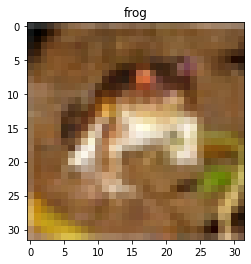

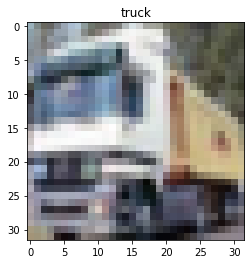

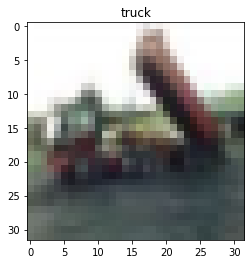

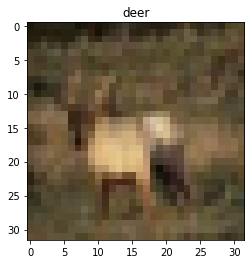

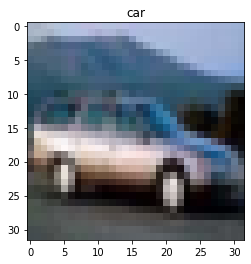

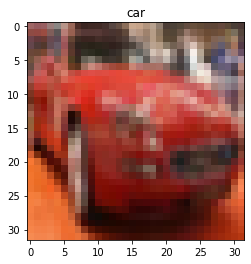

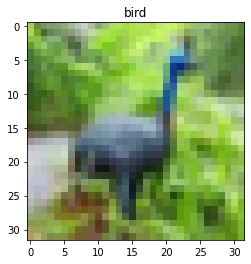

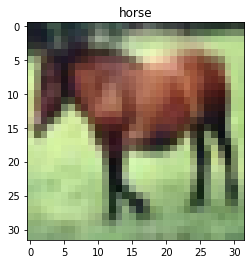

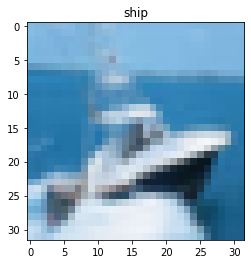

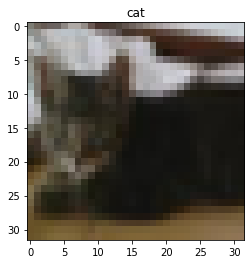

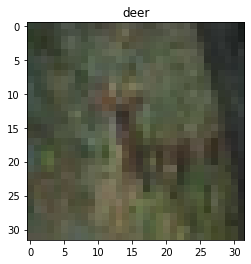

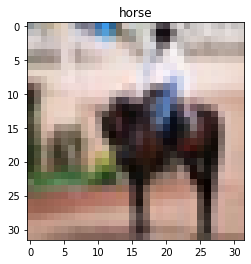

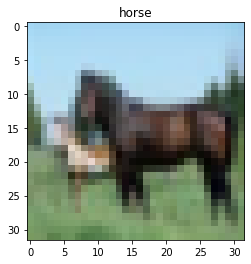

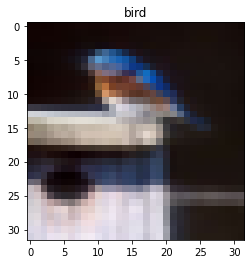

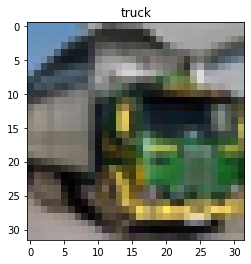

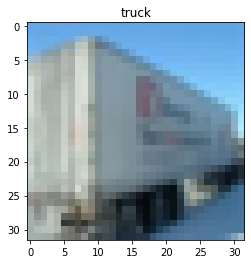

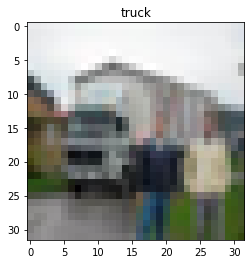

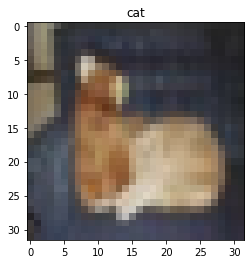

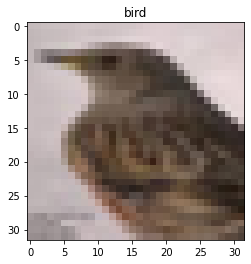

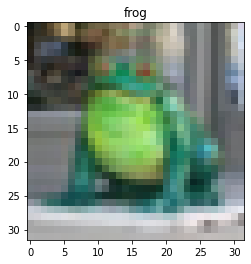

In [3]:

# The below two lines are optional and are just there to avoid any SSL
# related errors while downloading the CIFAR-10 dataset
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

#Initializing normalizing transform for the dataset
normalize_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = (0.5, 0.5, 0.5),
                                    std = (0.5, 0.5, 0.5))])

#Downloading the CIFAR10 dataset into train and test sets
train_dataset = torchvision.datasets.CIFAR10(
    root="./CIFAR10/train", train=True,
    transform=normalize_transform,
    download=True)
    
test_dataset = torchvision.datasets.CIFAR10(
    root="./CIFAR10/test", train=False,
    transform=normalize_transform,
    download=True)


#Generating data loaders from the corresponding datasets
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)




classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog',
'frog', 'horse', 'ship', 'truck')

# get first 100 training images
dataiter = iter(train_loader)
imgs, lbls = dataiter.next()

for i in range(20):  
    plt.title(classes[lbls[i]])
    imshow(imgs[i])

In [4]:
# check pytorch cuda and use cuda if possible
device = torch.cuda.is_available()
print('*' * 50)
if torch.cuda.is_available():  
  print('CUDA is found! Tranining on %s.......'%torch.cuda.get_device_name(0))
else:
  warnings.warn('CUDA not found! Training may be slow......')

**************************************************
CUDA is found! Tranining on NVIDIA GeForce RTX 2070 with Max-Q Design.......


## P1. Build you own CNN model 
### TODO
- Design your model class in **CNNModel(nn.Module)** and write forward pass in **forward(self, x)**
- Create loss function in **error**, optimizer in **optimizer**
- Define hyparparameters: **learning_rate**, **num_epochs**
- Plot your **loss vs num_epochs** and **accuracy vs num_epochs** 


###  Hints
- Start with low number of epochs for debugging. (eg. num_epochs=1)
- Be careful with the input dimension of fully connected layer. 
- The dimension calculation of the output tensor from the input tensor is \\
$D_{out}=\frac{D_{in}-K+2P}{S}+1$ \\
$D_{out}$ : Dimension of output tensor \\
$D_{in}$ : Dimension of input tensor \\
$K$ : width/height of the kernel \\
$S$ : stride \\
$P$ : padding

## Convolutional and Pooling Layers

A convolutional layer using pyTorch:



```
torch.nn.Conv2d(num_in_channels, num_out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
```
For example:
```
torch.nn.Conv2d(3, 32, 3)
```
It applies a 2D convolution over an input signal composed of several input planes. If we have input size with $(N, C_{in}, H, W)$ and output size with $(N, C_{out}, H_{out}, W_{out})$, the 2D convolution can described as $$out(N_i, C_{out_j}) = bias(C_{out_j}) + \sum_{k=0}^{C_{in}-1}weight(C_{out_j},k)\star input(N_i,k)$$

**num_in_channels:** is the number of channels of the input tensor. If the previous layer is the input layer, num_in_channels is the number of channels of the image (3 channels for RGB images), otherwise num_in_channels is equal to the number of feature maps of the previous layer.

**num_out_channels:** is the number of filters (feature extractor) that this layer will apply over the image or feature maps generated by the previous layer.

**kernel_size:** is the size of the convolving kernel

**stride:** is the stride of the convolution. Default: 1

**padding:** is the padding added to all four sides of the input. Default: 0

**dilation:** is the spacing between kernel elements. Default: 1

**group:** is the number of blocked connections from input channels to output channels. Default: 1

**bias:** If True, adds a learnable bias to the output. Default: True

## A Simple Convolutional Neural Network

In our convnet we'll initally use this structure shown below:

*input -> convolution -> fully connected -> output* \\


At the end of the last convolutional layer, we get a tensor of dimension (num_channels, height, width). Since now we are going to feed it to a fully connected layer, we need to convert it into a 1-D vector, and for that we use the reshape method:

```
x = x.view(x.size(0), -1)
```
The way of calculating size of the output size from previous convolution layer can be formulized as below: $$H_{output} = \frac{H_{in}+2\times padding-kernel\_Size}{stride}+1$$

For more details, you can refer to this link: \\
https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

In [5]:
class CNNModel(nn.Module):
  def __init__(self):
    super(CNNModel, self).__init__()
    # TODO: Create CNNModel using 2D convolution. You should vary the number of convolution layers and fully connected layers
    # In this function, you should define each of the individual components of the CNN that you will use in your network 
    # Example:  
    # self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
    # self.relu1 = nn.ReLU() 
    # self.maxpool1 = nn.MaxPool2d(kernel_size=2) 
    self.cnn1 = torch.nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5) 
    self.relu = torch.nn.ReLU()
    self.cnn2 = torch.nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 3) 
    self.cnn3 = torch.nn.Conv2d(in_channels = 16, out_channels = 24, kernel_size = 3) 
    
    # TODO: Create Fully connected layers. You should calculate the dimension of the input tensor from the previous layer 
    # Example: 
    # self.fc1 = nn.Linear(16 *110 * 110, 5)
    # Fully connected 1
    self.fc1 = torch.nn.Linear(24*24*24, 120)
    self.fc2 = torch.nn.Linear(120, 84)
    self.fc3 = torch.nn.Linear(84, 10)

  def forward(self,x):

    # TODO: Perform forward pass in below section 
    # In this function, you will apply the components defined earlier to the input, x.
    # Example:
    out = self.cnn1(x)
    out = self.relu(out)   
    out = self.cnn2(out)
    out = self.relu(out)  
    #plt.imshow(out[0][0].cpu().detach().numpy())
    #plt.show()
    #plt.close('all') 
    out = self.cnn3(out)
    out = self.relu(out)   
    #out = self.relu1(out)      
    # out = self.maxpool1(out) 
    # to visualize feature map in part a, part b.i), use the following three lines:
   
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.relu(out) 
    out = self.fc2(out)
    out = self.relu(out) 
    out = self.fc3(out)
    return out

## Starting Up Our Model

We'll send the model to our GPU if you have one so we need to create a CUDA device and instantiate our model. Then we will define the loss function and 
hyperparameters that we need to train the model: \\

###TODO
- Define Cross Entropy Loss
- Create Adam Optimizer
- Define hyperparameters 

In [6]:
# Create CNN
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNNModel()
model.to(device)

# TODO: define Cross Entropy Loss 
error = torch.nn.CrossEntropyLoss()

# TODO: create Adam Optimizer and define your hyperparameters 
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), learning_rate)
num_epochs = 20

from torchsummary import summary
batch_size = 16
summary(model, input_size=(3, 32, 32))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            456
├─ReLU: 1-2                              --
├─Conv2d: 1-3                            880
├─Conv2d: 1-4                            3,480
├─Linear: 1-5                            1,659,000
├─Linear: 1-6                            10,164
├─Linear: 1-7                            850
Total params: 1,674,830
Trainable params: 1,674,830
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            456
├─ReLU: 1-2                              --
├─Conv2d: 1-3                            880
├─Conv2d: 1-4                            3,480
├─Linear: 1-5                            1,659,000
├─Linear: 1-6                            10,164
├─Linear: 1-7                            850
Total params: 1,674,830
Trainable params: 1,674,830
Non-trainable params: 0

### Training the Model
### TODO 
- Make predictions from your model
- Calculate Cross Entropy Loss from predictions and labels 

In [7]:
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # TODO: Forward propagation
        outputs = model(images)
        
        # TODO: Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        
        # Backprop agate your Loss 
        torch.sum(loss).backward()
        
        # Update CNN model  
        optimizer.step()
        
        count += 1
        
        if count % 50 == 0:
            model.eval()
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                
                # Forward propagation
                outputs = model(images)
                
                # Get predictions from the maximum value
                predicted = torch.argmax(outputs,1)
                
                # Total number of labels
                total += len(labels)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.item())
            iteration_list.append(count)
            accuracy_list.append(accuracy.item())
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

  5%|▌         | 1/20 [00:39<12:22, 39.06s/it]

Iteration: 500  Loss: 1.3727850914001465  Accuracy: 51.8599967956543 %


 10%|█         | 2/20 [01:14<11:01, 36.77s/it]

Iteration: 1000  Loss: 1.1488912105560303  Accuracy: 59.34000015258789 %


 15%|█▌        | 3/20 [01:51<10:32, 37.19s/it]

Iteration: 1500  Loss: 0.8596102595329285  Accuracy: 61.46999740600586 %


 25%|██▌       | 5/20 [03:04<09:10, 36.67s/it]

Iteration: 2000  Loss: 0.941204845905304  Accuracy: 61.87999725341797 %


 30%|███       | 6/20 [03:37<08:17, 35.53s/it]

Iteration: 2500  Loss: 0.83780837059021  Accuracy: 62.68000030517578 %


 35%|███▌      | 7/20 [04:12<07:37, 35.20s/it]

Iteration: 3000  Loss: 0.8059139847755432  Accuracy: 61.82999801635742 %


 40%|████      | 8/20 [04:49<07:08, 35.74s/it]

Iteration: 3500  Loss: 0.5071962475776672  Accuracy: 57.68000030517578 %


 50%|█████     | 10/20 [06:02<06:01, 36.18s/it]

Iteration: 4000  Loss: 0.3492661714553833  Accuracy: 60.43000030517578 %


 55%|█████▌    | 11/20 [06:40<05:31, 36.88s/it]

Iteration: 4500  Loss: 0.37602102756500244  Accuracy: 58.279998779296875 %


 60%|██████    | 12/20 [07:14<04:47, 35.97s/it]

Iteration: 5000  Loss: 0.35433849692344666  Accuracy: 56.59000015258789 %


 70%|███████   | 14/20 [08:26<03:35, 35.91s/it]

Iteration: 5500  Loss: 0.19080926477909088  Accuracy: 58.25 %


 75%|███████▌  | 15/20 [09:02<02:59, 36.00s/it]

Iteration: 6000  Loss: 0.1000833660364151  Accuracy: 58.459999084472656 %


 80%|████████  | 16/20 [09:38<02:23, 35.87s/it]

Iteration: 6500  Loss: 0.2079406976699829  Accuracy: 57.599998474121094 %


 85%|████████▌ | 17/20 [10:09<01:43, 34.49s/it]

Iteration: 7000  Loss: 0.11518188565969467  Accuracy: 58.519996643066406 %


 95%|█████████▌| 19/20 [11:28<00:36, 36.95s/it]

Iteration: 7500  Loss: 0.23340679705142975  Accuracy: 55.98999786376953 %


100%|██████████| 20/20 [12:04<00:00, 36.23s/it]


In [8]:
# !pip install torchsummary
# uncomment above line if you don't have torchsummary installed yet
# Print torchsummary of model
from torchsummary import summary
print(summary(model, input_size = (3, 32, 32)))
print("Kernel Size: 3x3")

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            456
├─ReLU: 1-2                              --
├─Conv2d: 1-3                            880
├─Conv2d: 1-4                            3,480
├─Linear: 1-5                            1,659,000
├─Linear: 1-6                            10,164
├─Linear: 1-7                            850
Total params: 1,674,830
Trainable params: 1,674,830
Non-trainable params: 0
Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            456
├─ReLU: 1-2                              --
├─Conv2d: 1-3                            880
├─Conv2d: 1-4                            3,480
├─Linear: 1-5                            1,659,000
├─Linear: 1-6                            10,164
├─Linear: 1-7                            850
Total params: 1,674,830
Trainable params: 1,674,830
Non-trainable params: 0
Kernel Size: 3x3


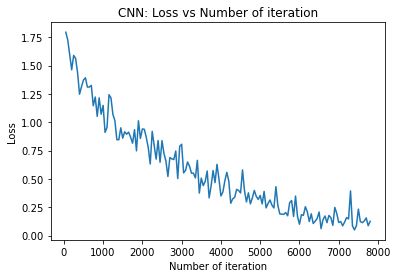

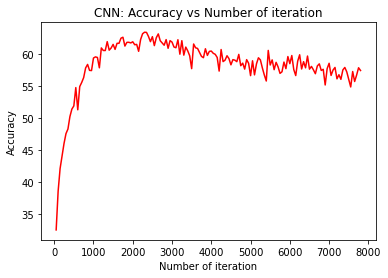

In [9]:
# visualization loss
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

### Evaluating the Model

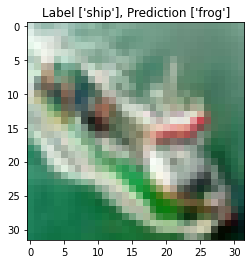

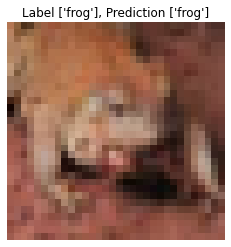

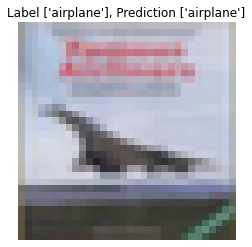

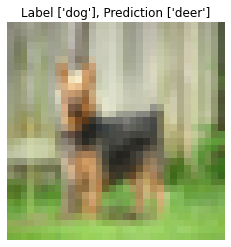

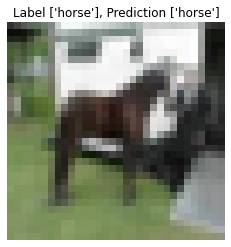

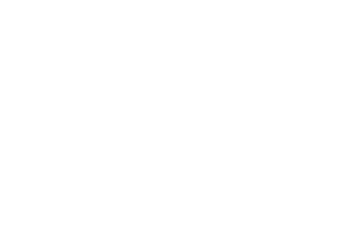

In [10]:
import random
#To-do: evaluate on test set, instead of training set
random_image = random.randint(0,len(test_dataset))
image = test_dataset.__getitem__(random_image)
model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
predictions = torch.argmax(model(images),1)
num_cols=1
num_rows = 25# len(labels)
label_map = [['airplane'],['automobile'],['bird'],['cat'], ['deer'], ['dog'], ['frog'], ['horse'], ['ship'], ['truck']]

r = list(range(num_rows))
random.shuffle(r)
rand_range = r[0:5]
for idx in rand_range:
  img = images.cpu()[idx]
  
  plt.title(f"Label {label_map[labels[idx]]}, Prediction {label_map[predictions[idx]]}")  
  imshow(img)

  plt.axis('off')

plt.show()

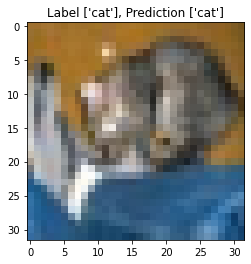

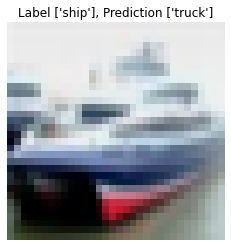

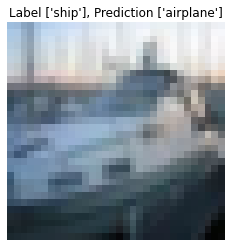

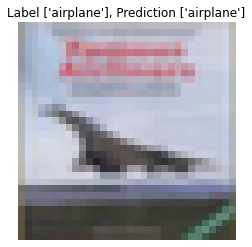

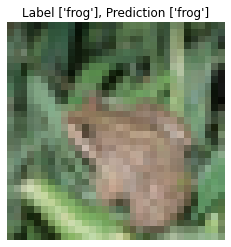

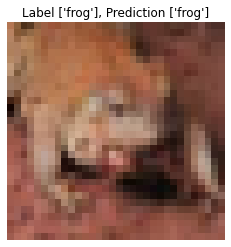

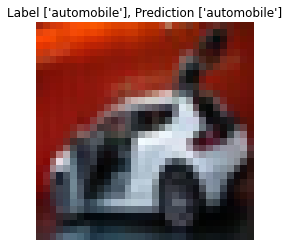

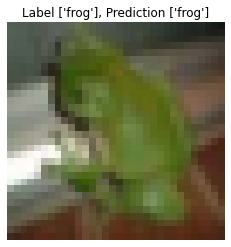

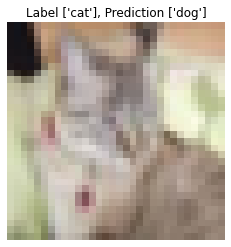

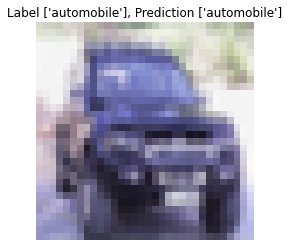

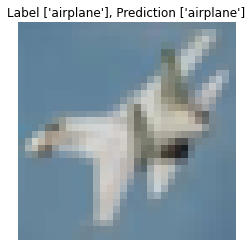

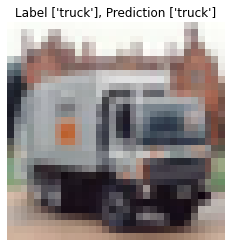

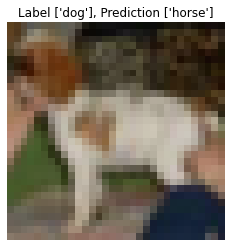

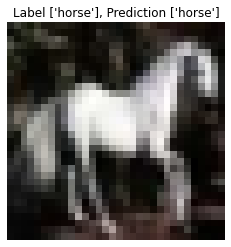

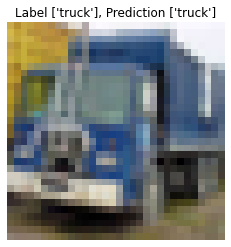

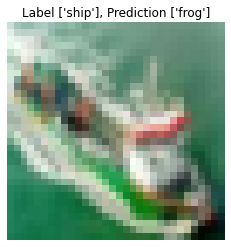

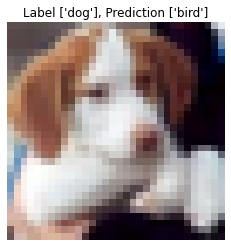

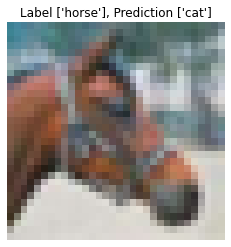

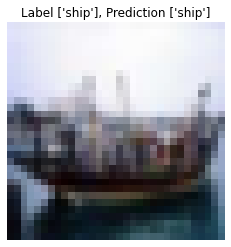

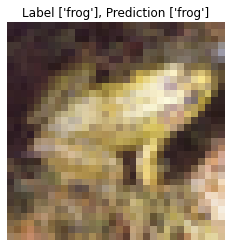

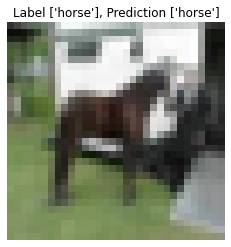

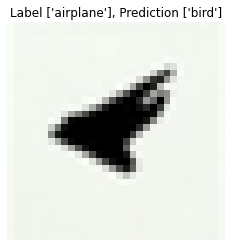

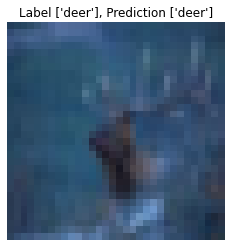

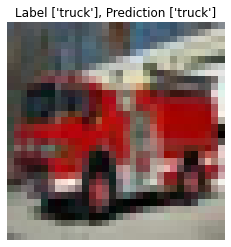

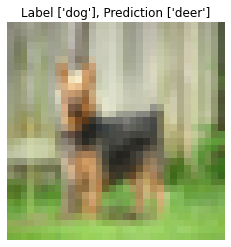

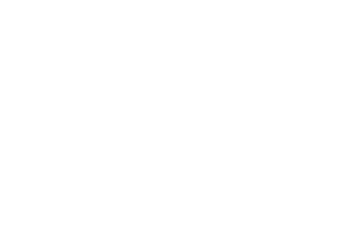

In [11]:
#To-do: evaluate on test set, instead of training set
random_image = random.randint(0,len(test_dataset))
image = test_dataset.__getitem__(random_image)
model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
predictions = torch.argmax(model(images),1)
num_cols=1
num_rows = 25# len(labels)
label_map = [['airplane'],['automobile'],['bird'],['cat'], ['deer'], ['dog'], ['frog'], ['horse'], ['ship'], ['truck']]

for idx in range(num_rows):
  img = images.cpu()[idx]
  
  plt.title(f"Label {label_map[labels[idx]]}, Prediction {label_map[predictions[idx]]}")  
  imshow(img)

  plt.axis('off')
plt.show()

# Part 2: Additional Components
i.)


In [12]:
class CNNModel(nn.Module):
  def __init__(self):
    super(CNNModel, self).__init__()
    # TODO: Create CNNModel using 2D convolution. You should vary the number of convolution layers and fully connected layers
    # In this function, you should define each of the individual components of the CNN that you will use in your network 
    # Example:  
    # self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
    # self.relu1 = nn.ReLU() 
    # self.maxpool1 = nn.MaxPool2d(kernel_size=2) 
    self.cnn1 = torch.nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5) 
    self.relu = torch.nn.ReLU()
    self.cnn2 = torch.nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 3)

    self.maxpool1 = nn.MaxPool2d(2) 

    self.cnn3 = torch.nn.Conv2d(in_channels = 16, out_channels = 24, kernel_size = 3)
    self.cnn4 = torch.nn.Conv2d(in_channels = 24, out_channels = 24, kernel_size = 3) 
    self.cnn5 = torch.nn.Conv2d(in_channels = 24, out_channels = 24, kernel_size = 3)  
    
    # TODO: Create Fully connected layers. You should calculate the dimension of the input tensor from the previous layer 
    # Example: 
    # self.fc1 = nn.Linear(16 *110 * 110, 5)
    # Fully connected 1
    self.fc1 = torch.nn.Linear(13824, 120)
    self.fc2 = torch.nn.Linear(120, 84)
    self.fc3 = torch.nn.Linear(84, 10)

  def forward(self,x):

    # TODO: Perform forward pass in below section 
    # In this function, you will apply the components defined earlier to the input, x.
    # Example:
    out = self.cnn1(x)
    out = self.relu(out)   
    out = self.cnn2(out)
    out = self.relu(out)  
    #plt.imshow(out[0][0].cpu().detach().numpy())
    #plt.show()
    #plt.close('all') 
    out = self.cnn3(out)
    out = self.relu(out)   
    #out = self.relu1(out)      
    # out = self.maxpool1(out) 
    # to visualize feature map in part a, part b.i), use the following three lines:
   
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.relu(out) 
    out = self.fc2(out)
    out = self.relu(out) 
    out = self.fc3(out)
    return out

  # Create CNN
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNNModel()
model.to(device)

# TODO: define Cross Entropy Loss 
error = torch.nn.CrossEntropyLoss()

# TODO: create Adam Optimizer and define your hyperparameters 
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 20

from torchsummary import summary
print(summary(model,input_size=(3, 32, 32)))

count = 0
loss_list_bi = []
iteration_list_bi = []
accuracy_list_bi = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # TODO: Forward propagation
        outputs = model(images)
        
        # TODO: Calculate softmax and cross entropy loss
        loss = error(outputs,labels)
        
        # Backprop agate your Loss 
        T = torch.sum(loss)
        T.backward()
        
        # Update CNN model  
        optimizer.step()
        
        count += 1
        
        if count % 50 == 0:
            model.eval()
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                
                # Forward propagation
                outputs = model(images)
                
                # Get predictions from the maximum value
                predicted = torch.argmax(outputs,1)
                
                # Total number of labels
                total = total + len(labels)
                correct = correct + (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list_bi.append(loss.item())
            iteration_list_bi.append(count)
            accuracy_list_bi.append(accuracy.item())
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))



Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            456
├─ReLU: 1-2                              --
├─Conv2d: 1-3                            880
├─MaxPool2d: 1-4                         --
├─Conv2d: 1-5                            3,480
├─Conv2d: 1-6                            5,208
├─Conv2d: 1-7                            5,208
├─Linear: 1-8                            1,659,000
├─Linear: 1-9                            10,164
├─Linear: 1-10                           850
Total params: 1,685,246
Trainable params: 1,685,246
Non-trainable params: 0
Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            456
├─ReLU: 1-2                              --
├─Conv2d: 1-3                            880
├─MaxPool2d: 1-4                         --
├─Conv2d: 1-5                            3,480
├─Conv2d: 1-6                            5,208
├─Conv2d: 1-7                            5,208
├─Linear: 1-8                            1,6

  5%|▌         | 1/20 [00:31<10:03, 31.79s/it]

Iteration: 500  Loss: 1.284759521484375  Accuracy: 50.55999755859375 %


 10%|█         | 2/20 [01:08<10:23, 34.62s/it]

Iteration: 1000  Loss: 1.1590650081634521  Accuracy: 57.529998779296875 %


 15%|█▌        | 3/20 [01:43<09:51, 34.81s/it]

Iteration: 1500  Loss: 0.8989694714546204  Accuracy: 60.04999923706055 %


 25%|██▌       | 5/20 [02:55<08:55, 35.72s/it]

Iteration: 2000  Loss: 0.8936105370521545  Accuracy: 61.47999954223633 %


 30%|███       | 6/20 [03:27<08:03, 34.54s/it]

Iteration: 2500  Loss: 0.6931913495063782  Accuracy: 61.0099983215332 %


 35%|███▌      | 7/20 [04:03<07:31, 34.74s/it]

Iteration: 3000  Loss: 0.816838264465332  Accuracy: 58.89999771118164 %


 40%|████      | 8/20 [04:37<06:54, 34.55s/it]

Iteration: 3500  Loss: 0.6166757941246033  Accuracy: 58.31999969482422 %


 50%|█████     | 10/20 [05:43<05:38, 33.87s/it]

Iteration: 4000  Loss: 0.6007229089736938  Accuracy: 58.769996643066406 %


 55%|█████▌    | 11/20 [06:16<05:00, 33.39s/it]

Iteration: 4500  Loss: 0.5166906118392944  Accuracy: 57.41999816894531 %


 60%|██████    | 12/20 [06:46<04:19, 32.43s/it]

Iteration: 5000  Loss: 0.31766220927238464  Accuracy: 57.119998931884766 %


 70%|███████   | 14/20 [07:54<03:20, 33.37s/it]

Iteration: 5500  Loss: 0.25976741313934326  Accuracy: 56.5 %


 75%|███████▌  | 15/20 [08:28<02:46, 33.32s/it]

Iteration: 6000  Loss: 0.3657153844833374  Accuracy: 56.05999755859375 %


 80%|████████  | 16/20 [09:01<02:13, 33.48s/it]

Iteration: 6500  Loss: 0.27545157074928284  Accuracy: 57.73999786376953 %


 85%|████████▌ | 17/20 [09:33<01:38, 32.99s/it]

Iteration: 7000  Loss: 0.1770372986793518  Accuracy: 56.87999725341797 %


 95%|█████████▌| 19/20 [10:41<00:33, 33.41s/it]

Iteration: 7500  Loss: 0.1567377895116806  Accuracy: 57.439998626708984 %


100%|██████████| 20/20 [11:14<00:00, 33.73s/it]


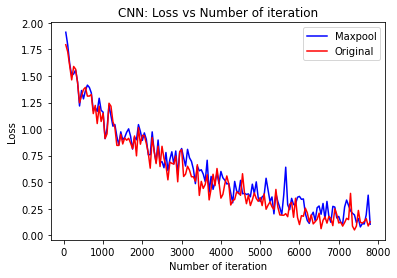

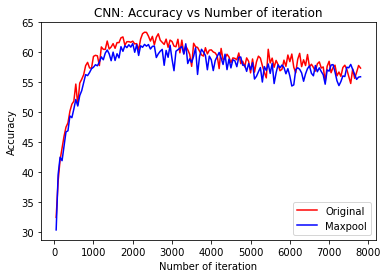


Memory Required for Model: 6.85 MB

In terms of observations, it seems that the Maxpool and Original method seem to have similar trends for the 
accuracy and loss rate. However, it appears that Maxpool method is slightly less accurate than the original method.


In [13]:
# visualization loss
plt.plot(iteration_list_bi,loss_list_bi, color = "blue", label = 'Maxpool')
plt.plot(iteration_list,loss_list, color = "red", label = 'Original')
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.legend()
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red", label = 'Original')
plt.plot(iteration_list_bi,accuracy_list_bi,color = "blue", label = 'Maxpool')
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.legend()
plt.show()

print("\nMemory Required for Model: 6.85 MB")
print("\nIn terms of observations, it seems that the Maxpool and Original method seem to have similar trends for the \naccuracy and loss rate. However, it appears that Maxpool method is slightly less accurate than the original method.")

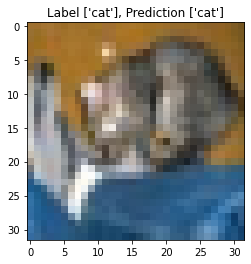

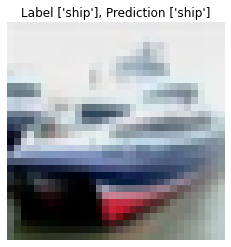

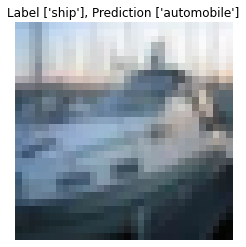

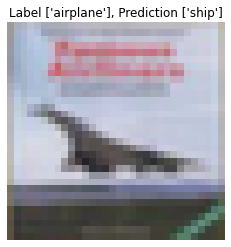

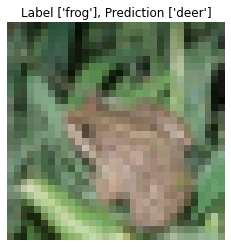

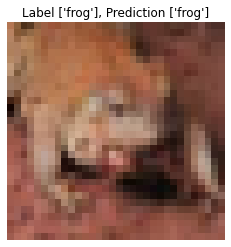

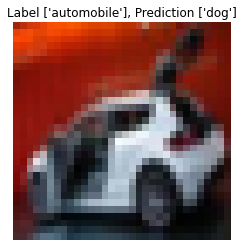

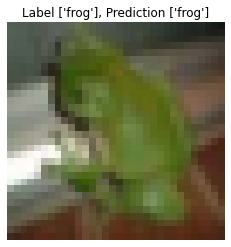

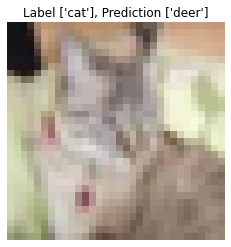

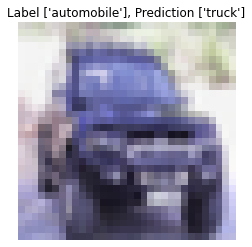

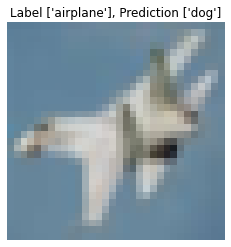

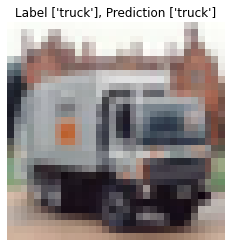

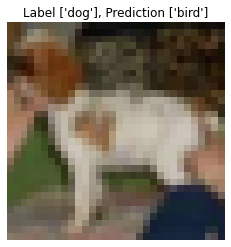

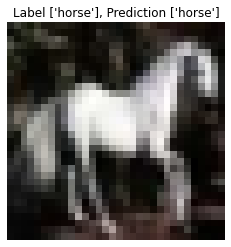

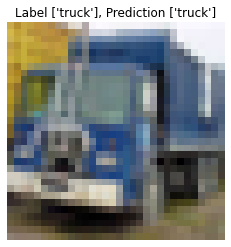

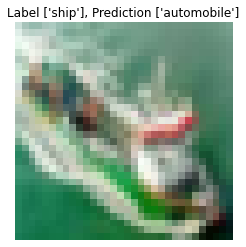

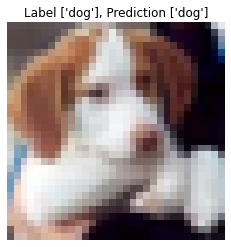

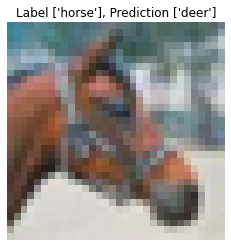

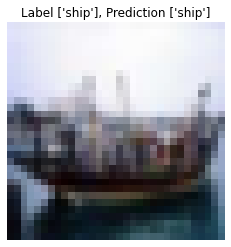

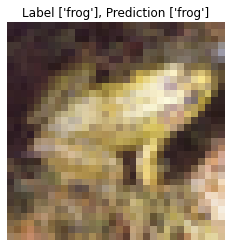

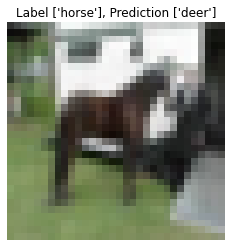

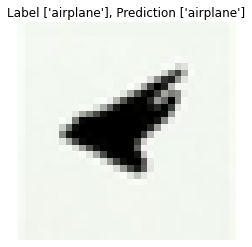

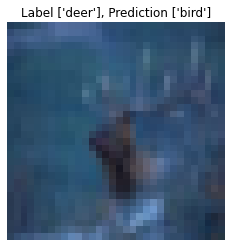

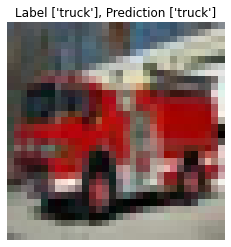

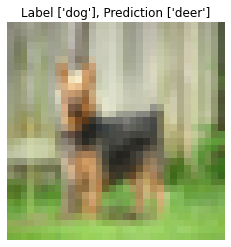

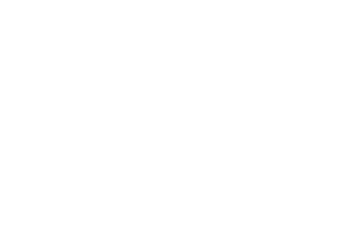

In [14]:
#To-do: evaluate on test set, instead of training set
random_image = random.randint(0,len(test_dataset))
image = test_dataset.__getitem__(random_image)
model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
predictions = torch.argmax(model(images),1)
num_cols = 1
num_rows = 25# len(labels)
label_map = [['airplane'],['automobile'],['bird'],['cat'], ['deer'], ['dog'], ['frog'], ['horse'], ['ship'], ['truck']]

for idx in range(num_rows):
  img = images.cpu()[idx]
  
  plt.title(f"Label {label_map[labels[idx]]}, Prediction {label_map[predictions[idx]]}")  
  imshow(img)

  plt.axis('off')
plt.show()

ii.)

In [15]:
class CNNModel(nn.Module):
  def __init__(self):
    super(CNNModel, self).__init__()
    # TODO: Create CNNModel using 2D convolution. You should vary the number of convolution layers and fully connected layers
    # In this function, you should define each of the individual components of the CNN that you will use in your network 
    # Example:  
    self.cnn1 = torch.nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5)
    self.relu = torch.nn.ReLU()
    #Input = 6 x 28 x 28, Output = 16 x 26 x 26
    self.cnn2 =torch.nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 3)


    self.maxpool1 = nn.MaxPool2d(2)

    self.cnn3 = torch.nn.Conv2d(in_channels = 16, out_channels = 24, kernel_size = 3)
    self.cnn4 = torch.nn.Conv2d(in_channels = 24, out_channels = 24, kernel_size = 3)
    self.cnn5 = torch.nn.Conv2d(in_channels = 24, out_channels = 24, kernel_size = 3)

    
    # TODO: Create Fully connected layers. You should calculate the dimension of the input tensor from the previous layer 
    # Example: 
    # self.fc1 = nn.Linear(16 *110 * 110, 5)
    # Fully connected 1
    self.fc1 = torch.nn.Linear(24*7*7, 120)
    self.fc2 = torch.nn.Linear(120, 84)
    self.fc3 = torch.nn.Linear(84, 10)
    

  def forward(self,x):

    # TODO: Perform forward pass in below section 
    # In this function, you will apply the components defined earlier to the input, x.
    # Example:
    out = self.cnn1(x)
    out = self.relu(out)   
    out = self.cnn2(out)
    out = self.relu(out)  
    #plt.imshow(out[0][0].cpu().detach().numpy())
    #plt.show()
    #plt.close('all') 
    out = self.maxpool1(out)
    out = self.cnn3(out)
    out = self.relu(out)   
    out = self.cnn4(out)
    out = self.relu(out)   
    out = self.cnn5(out)
    out = self.relu(out)  
    #out = self.relu1(out)      
     
    # to visualize feature map in part a, part b.i), use the following three lines:
   
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.relu(out) 
    out = self.fc2(out)
    out = self.relu(out) 
    out = self.fc3(out)

    return out

# Create CNN
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNNModel()
model.to(device)

# TODO: define Cross Entropy Loss 
error = torch.nn.CrossEntropyLoss()

# TODO: create Adam Optimizer and define your hyperparameters 
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 20

from torchsummary import summary
print(summary(model,input_size=(3, 32, 32)))

count = 0
loss_list_bii = []
iteration_list_bii = []
accuracy_list_bii = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # TODO: Forward propagation
        outputs = model(images)
        
        # TODO: Calculate softmax and cross entropy loss
        loss = error(outputs,labels)
        
        # Backprop agate your Loss 
        T = torch.sum(loss)
        T.backward()
        
        # Update CNN model  
        optimizer.step()
        count = count + 1
        
        if count % 50 == 0:
            model.eval()
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                
                # Forward propagation
                outputs = model(images)
                
                # Get predictions from the maximum value
                predicted = torch.argmax(outputs,1)
                
                # Total number of labels
                total = total + len(labels)
                
                correct = correct + (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list_bii.append(loss.item())
            iteration_list_bii.append(count)
            accuracy_list_bii.append(accuracy.item())
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            456
├─ReLU: 1-2                              --
├─Conv2d: 1-3                            880
├─MaxPool2d: 1-4                         --
├─Conv2d: 1-5                            3,480
├─Conv2d: 1-6                            5,208
├─Conv2d: 1-7                            5,208
├─Linear: 1-8                            141,240
├─Linear: 1-9                            10,164
├─Linear: 1-10                           850
Total params: 167,486
Trainable params: 167,486
Non-trainable params: 0
Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            456
├─ReLU: 1-2                              --
├─Conv2d: 1-3                            880
├─MaxPool2d: 1-4                         --
├─Conv2d: 1-5                            3,480
├─Conv2d: 1-6                            5,208
├─Conv2d: 1-7                            5,208
├─Linear: 1-8                            141,240
├

  5%|▌         | 1/20 [00:31<10:01, 31.66s/it]

Iteration: 500  Loss: 1.5793367624282837  Accuracy: 40.55999755859375 %


 10%|█         | 2/20 [01:07<10:13, 34.07s/it]

Iteration: 1000  Loss: 1.415574073791504  Accuracy: 47.34000015258789 %


 15%|█▌        | 3/20 [01:42<09:44, 34.39s/it]

Iteration: 1500  Loss: 1.2583825588226318  Accuracy: 53.87999725341797 %


 25%|██▌       | 5/20 [02:51<08:39, 34.63s/it]

Iteration: 2000  Loss: 1.2385494709014893  Accuracy: 55.21999740600586 %


 30%|███       | 6/20 [03:20<07:36, 32.60s/it]

Iteration: 2500  Loss: 1.1462451219558716  Accuracy: 58.21999740600586 %


 35%|███▌      | 7/20 [03:50<06:51, 31.62s/it]

Iteration: 3000  Loss: 1.3434181213378906  Accuracy: 58.55999755859375 %


 40%|████      | 8/20 [04:23<06:27, 32.28s/it]

Iteration: 3500  Loss: 0.960294783115387  Accuracy: 60.349998474121094 %


 50%|█████     | 10/20 [05:30<05:26, 32.68s/it]

Iteration: 4000  Loss: 0.9490000009536743  Accuracy: 58.87999725341797 %


 55%|█████▌    | 11/20 [06:04<04:57, 33.04s/it]

Iteration: 4500  Loss: 0.9997236132621765  Accuracy: 60.18000030517578 %


 60%|██████    | 12/20 [06:36<04:22, 32.79s/it]

Iteration: 5000  Loss: 0.9303755164146423  Accuracy: 62.22999954223633 %


 70%|███████   | 14/20 [07:45<03:21, 33.65s/it]

Iteration: 5500  Loss: 0.8039083480834961  Accuracy: 63.18000030517578 %


 75%|███████▌  | 15/20 [08:20<02:50, 34.13s/it]

Iteration: 6000  Loss: 0.7739051580429077  Accuracy: 63.029998779296875 %


 80%|████████  | 16/20 [08:56<02:18, 34.59s/it]

Iteration: 6500  Loss: 1.0581154823303223  Accuracy: 62.97999954223633 %


 85%|████████▌ | 17/20 [09:29<01:42, 34.22s/it]

Iteration: 7000  Loss: 0.8343865871429443  Accuracy: 63.349998474121094 %


 95%|█████████▌| 19/20 [10:39<00:34, 34.81s/it]

Iteration: 7500  Loss: 0.9185515642166138  Accuracy: 62.66999816894531 %


100%|██████████| 20/20 [11:15<00:00, 33.77s/it]


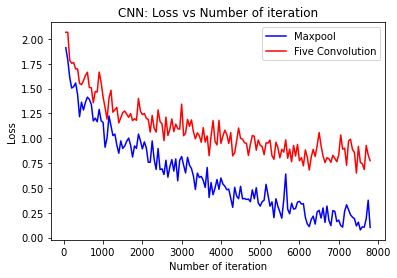

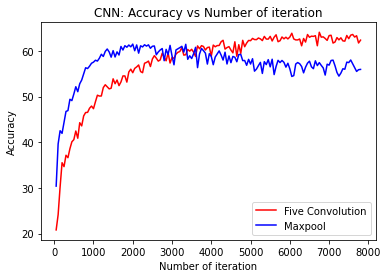


Memory Required for Model: 1.00 MB


In [16]:
# visualization loss
plt.plot(iteration_list_bi,loss_list_bi, color = "blue", label = 'Maxpool')
plt.plot(iteration_list_bii,loss_list_bii, color = "red", label = 'Five Convolution')
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.legend()
plt.show()

# visualization accuracy 
plt.plot(iteration_list_bii,accuracy_list_bii,color = "red", label = 'Five Convolution')
plt.plot(iteration_list_bi,accuracy_list_bi,color = "blue", label = 'Maxpool')
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.legend()
plt.show()

print("\nMemory Required for Model: 1.00 MB")

In [17]:
print("As the method in part 3 uses more training hyper parameters than 2, we can see that it tends to be \nmore accurate and takes up much less memory as well \nrelative to the older method. However, the drawback to this is that we have a decrease in loss compared to older methods \ndue to the more channels used to counter hyperparameters.")

As the method in part 3 uses more training hyper parameters than 2, we can see that it tends to be 
more accurate and takes up much less memory as well 
relative to the older method. However, the drawback to this is that we have a decrease in loss compared to older methods 
due to the more channels used to counter hyperparameters.
